# Задача 3. Сравнение методов классификации
Шлегель АВ группа 20.Б11-мм (471)

In [193]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_palette("colorblind")

# Датасет для предсказания заболеваний сердца

Этот набор данных содержит информацию о заболеваниях сердца у пациентов.

Признаки:
- **age** - возраст в годах,
- **sex** - пол (1 = мужской; 0 = женский),
- **cp** - тип боли в груди (0-3),
- **trestbps** - артериальное давление в состоянии покоя при поступлении в больницу (в мм рт. ст.),
- **chol** - холестерин в крови (в мг/дл),
- **fbs** - превышает ли сахар натощак 120 мг/дл (1 = истинно; 0 = ложно),
- **restecg** - результаты электрокардиографии в состоянии покоя (0-2),
- **thalach** - достигнутая максимальная частота сердечных сокращений,
- **exang** - наличие стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет),
- **oldpeak** - величина ST-недостаточности, вызванная физической нагрузкой по сравнению с покоем,
- **slope** - наклон сегмента ST пиковой физической нагрузки,
- **ca** - количество крупных сосудов (0 - 4), окрашенных при флоуроскопии,
- **thal** - наличие талассемии и её тип (0-3).

Целевой признак:
- **target** - есть болезнь или нет (1 = да; 0 = нет).

In [195]:
df = pd.read_csv("../../data/heart_disease/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.

## EDA
### target

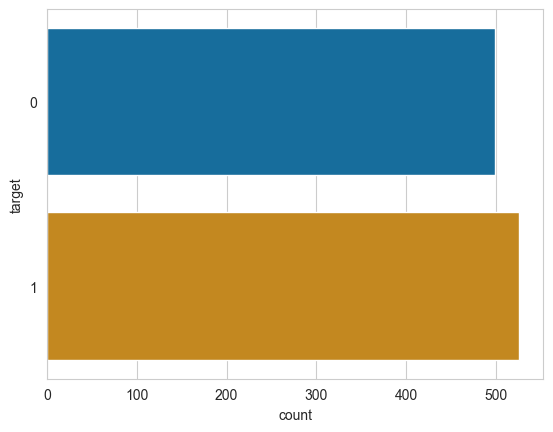

In [197]:
sns.countplot(data=df, y="target", palette="colorblind")
plt.show()

In [198]:
df.target.value_counts()

target
1    526
0    499
Name: count, dtype: int64

Выборка сбалансирована, так как количество пациентов с заболеванием сердца соответствует половине выборки.
### sex

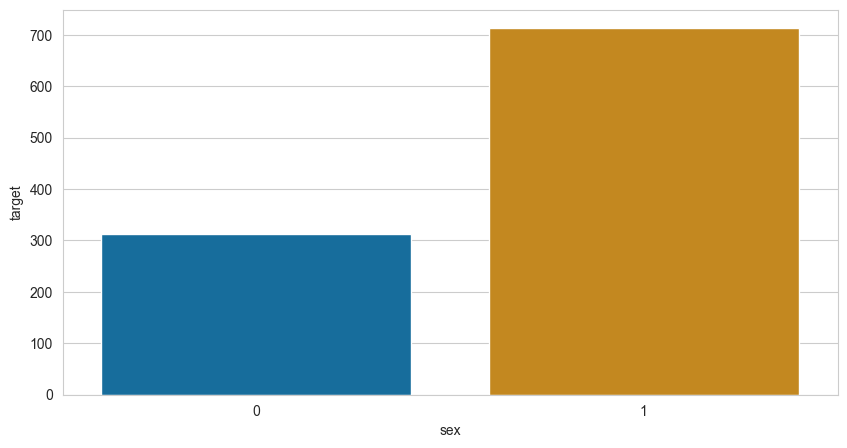

In [199]:
desease_count = df['target'].groupby(df['sex']).count()
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.barplot(x=desease_count.index, y=desease_count, palette="colorblind")

Пациенты мужского пола с жалобами на сердце встречаются более, чем в **2** раза чаще, чем женского пола.

### cp

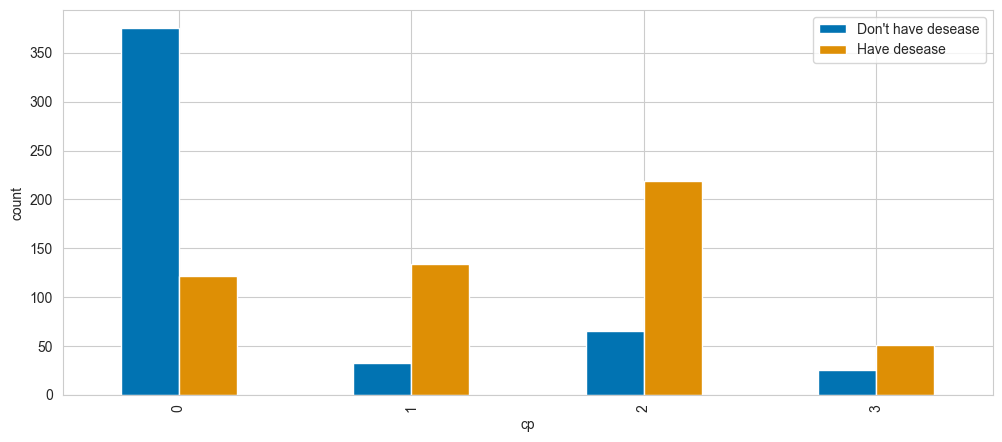

In [200]:
pd.crosstab(df.cp, df.target).plot(kind="bar", figsize=(12, 5))
plt.xlabel('cp')
plt.ylabel('count')
plt.legend(["Don't have desease", "Have desease"])
plt.show()

Примерно половина пациентов обращается с типом боли **0**, самой непопулярной болью оказалась **3**.

Несмотря на то, что чаще всего у пациентов фиксировали тип боли **0**, до заболевания доходило в разы меньше.
Почти каждый пациент с типом боли **1 и 2** получал неутешительный результат.
Больше половины пациентов с типом боли **3** имели заболевание сердца.

### fbs, restecg, exang, slope, ca, thal

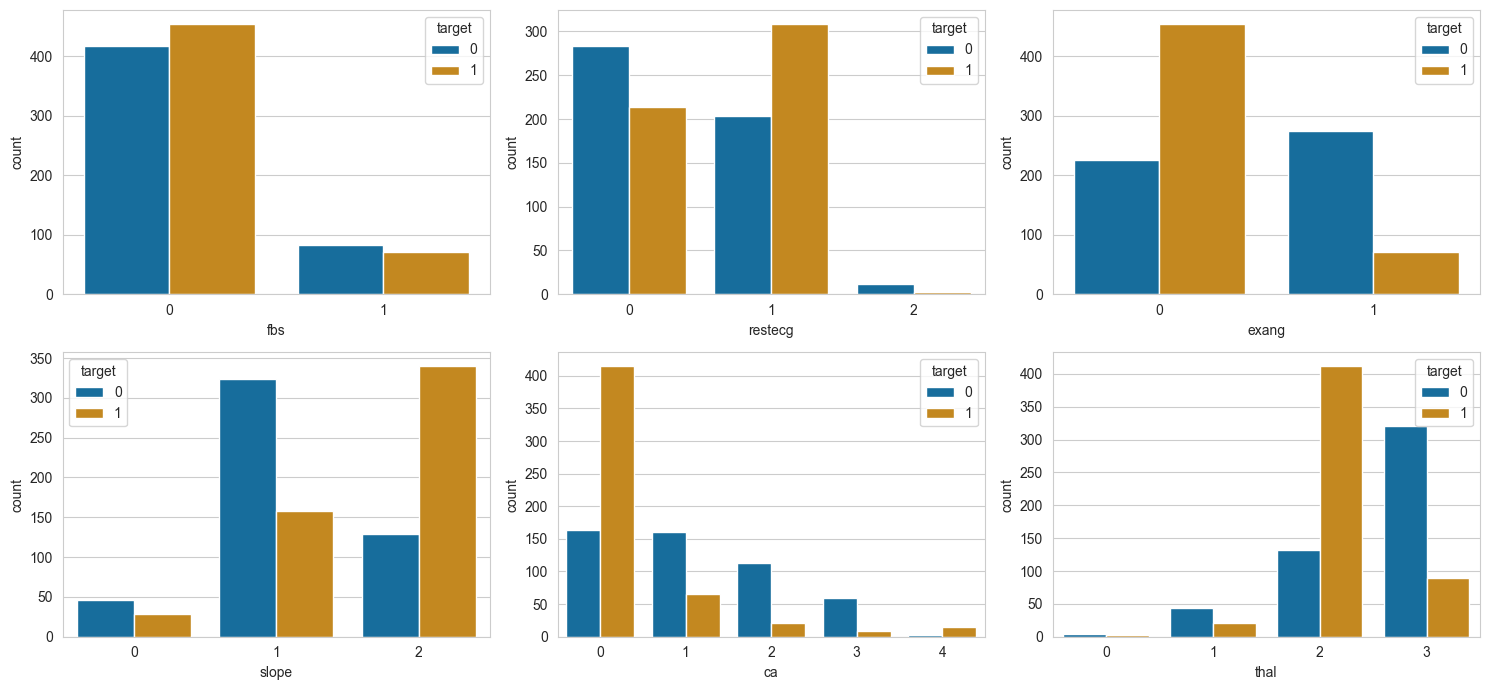

In [201]:
categorical = ["fbs", "restecg", "exang", "slope", "ca", "thal"]
_, axs = plt.subplots(2, 3, figsize=(15, 7), tight_layout=True)
for i in range(2):
    for j in range(3):
        name = categorical[i * 3 + j]
        sns.countplot(df, x=name, hue="target", ax=axs[i, j])

видим, fbs и restecg почти не влияет на целевой признак. Остальные влияют, но не тривиально. Необходимо преобразование как минимум для thal, cp

### age

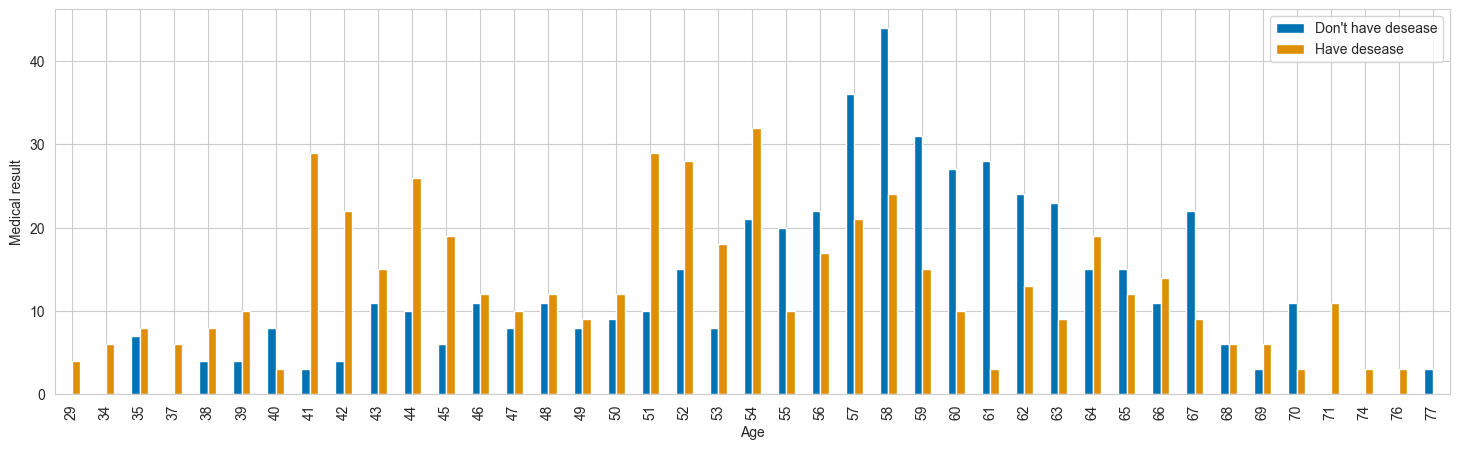

In [202]:
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(18, 5))
plt.xlabel('Age')
plt.ylabel('Medical result')
plt.legend(["Don't have desease", "Have desease"])
plt.show()

Люди **до 55** при приходе на обследование скорее имели болезнь, чем нет.
Люди **от 55 до 70** чаще проверялись, поэтому много без болезней.

### Все характеристики вместе

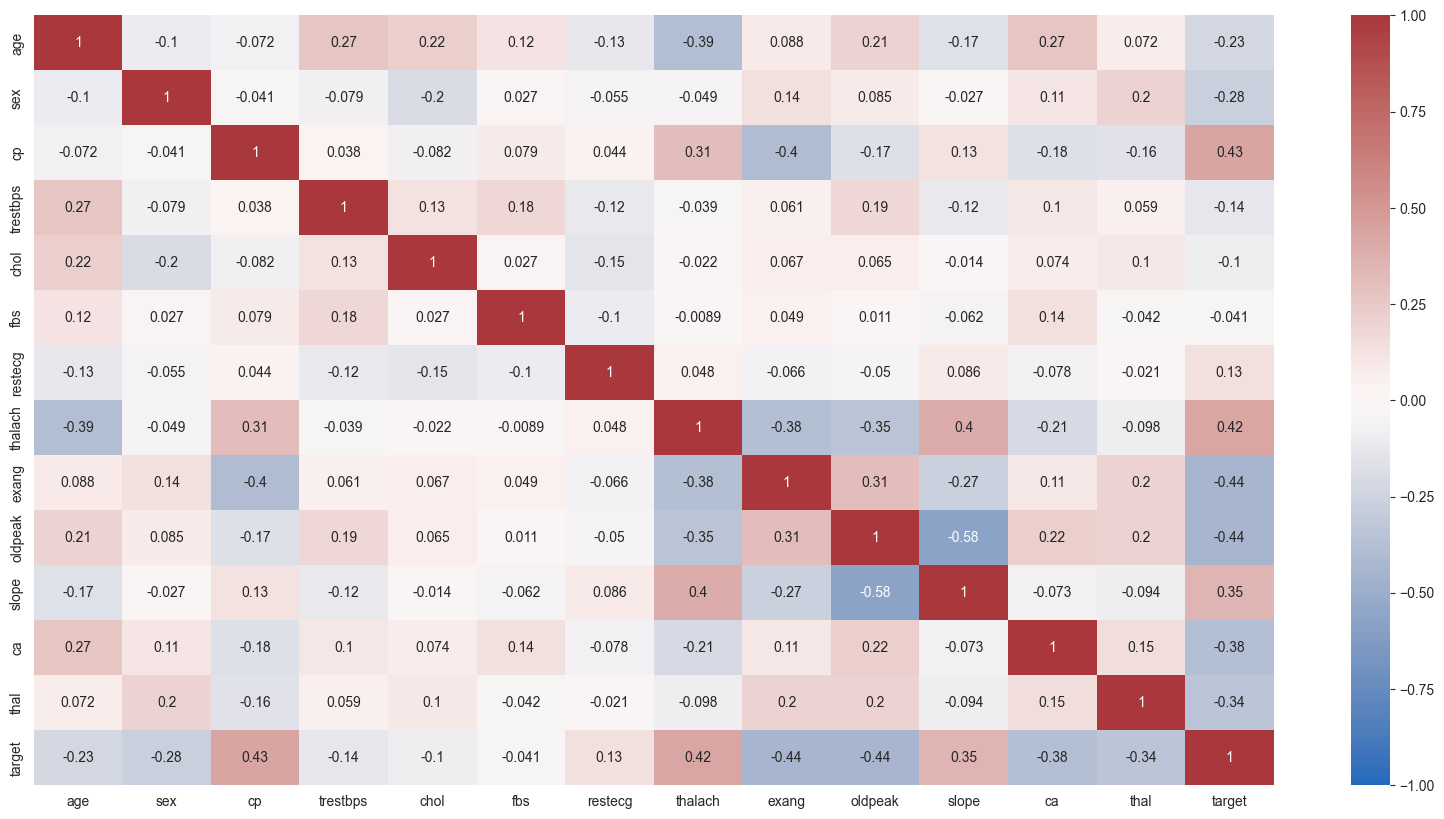

In [203]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(df.corr(), vmin=-1, annot=True, cmap="vlag")

Хорошую корреляцию продемонстрировали **cp, thalach, exang, oldpeack, scope, ca, thal**
При этом thalach, age связаны со всем

### thalach and age
Оценим влияние максимальной частоты сокращений сердца и возраста на заболевания сердца.

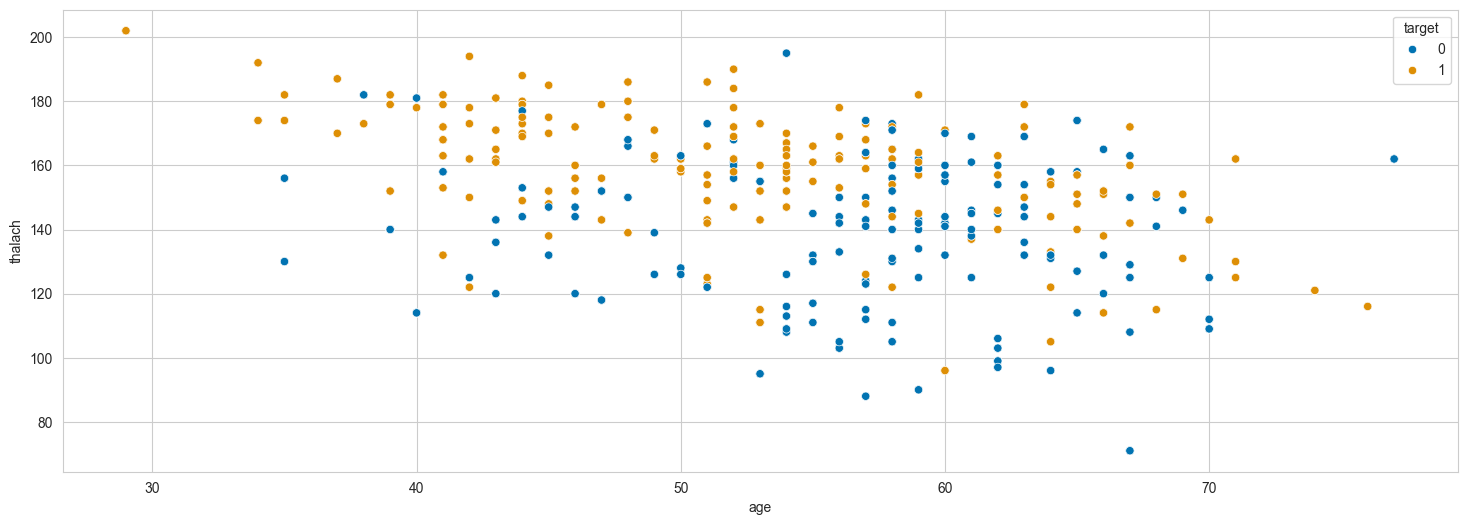

In [204]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
ax = sns.scatterplot(x='age', y='thalach', hue='target', data=df)

Исходя из распределения, пациенты в возрасте до **56** лет, которые получили положительный результат теста на заболевание сердца, имели более высокую частоту сердечных сокращений, чем здоровые. Чем дольше тем больший разброс.

### thalach and oldpeak

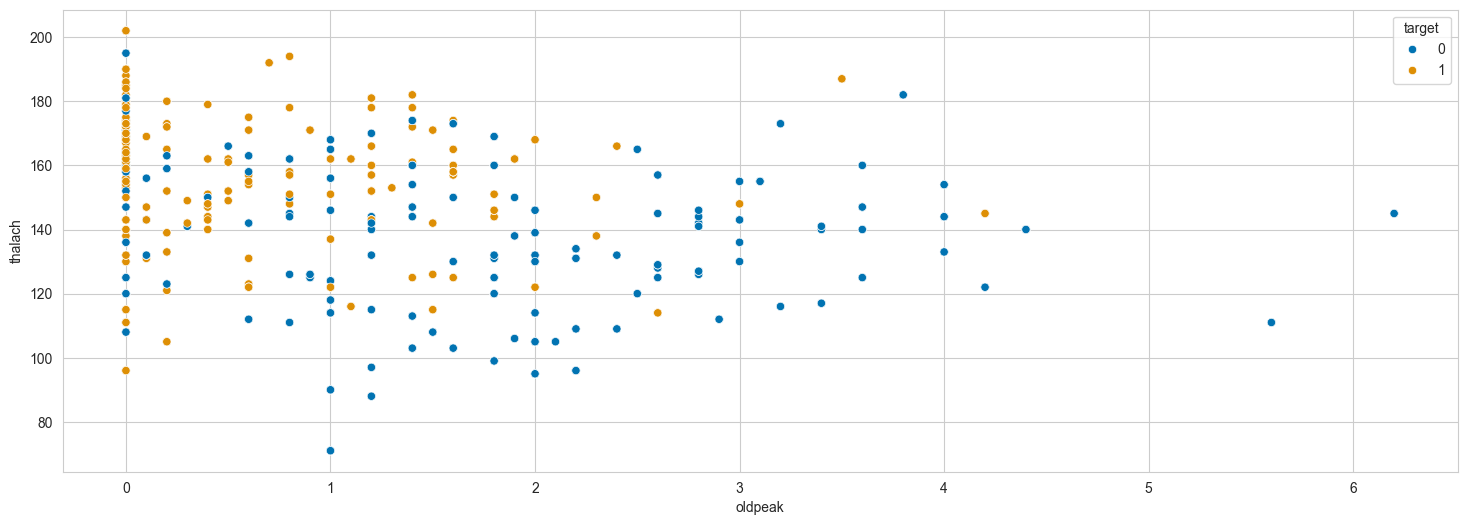

In [205]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
ax = sns.scatterplot(x='oldpeak', y='thalach', hue='target', data=df)

Хорошо видна связь между тремя параметрами.


### thalach and cp, exang, slope
Частота сердечных сокращений часто связана с переносимой физической нагрузкой. Рассмотрим эти признаки вместе.

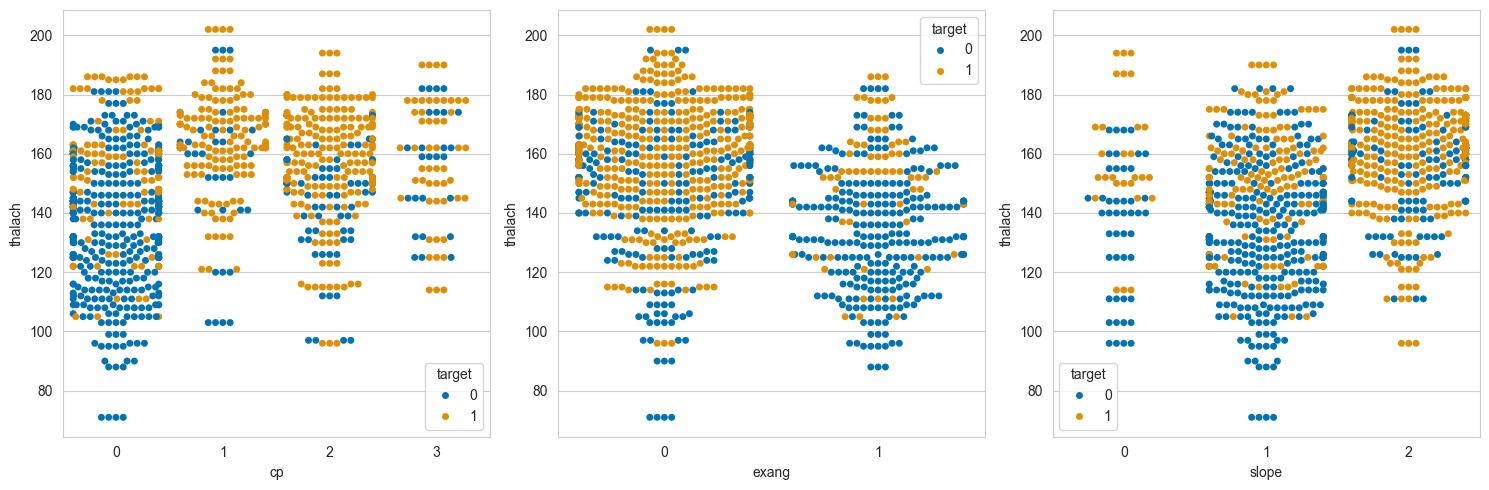

In [206]:
fs = ["cp", "exang", "slope"]
_, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
for i in range(3):
    name = fs[i]
    sns.swarmplot(x=name, y='thalach', hue='target', data=df, ax=axs[i])

Видим что есть значения, при которых мало данных (cp=3 и slope=0)

## Преобразование признаков (Feature Engineering)

В датасете содержатся категориальные признаки **cp**, **slope**, и **thal**, чье разделение может улучшить их корреляцию с целевым признаком.

In [207]:
cp_dum = pd.get_dummies(df['cp'], prefix="cp")
thal_dum = pd.get_dummies(df['thal'], prefix="thal")
slope_dum = pd.get_dummies(df['slope'], prefix="slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis=1).drop(columns=['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,False,False,False,False,False,False,True,False,False,True
1,53,1,140,203,1,0,155,1,3.1,0,...,False,False,False,False,False,False,True,True,False,False
2,70,1,145,174,0,1,125,1,2.6,0,...,False,False,False,False,False,False,True,True,False,False
3,61,1,148,203,0,1,161,0,0.0,1,...,False,False,False,False,False,False,True,False,False,True
4,62,0,138,294,1,1,106,0,1.9,3,...,False,False,False,False,False,True,False,False,True,False


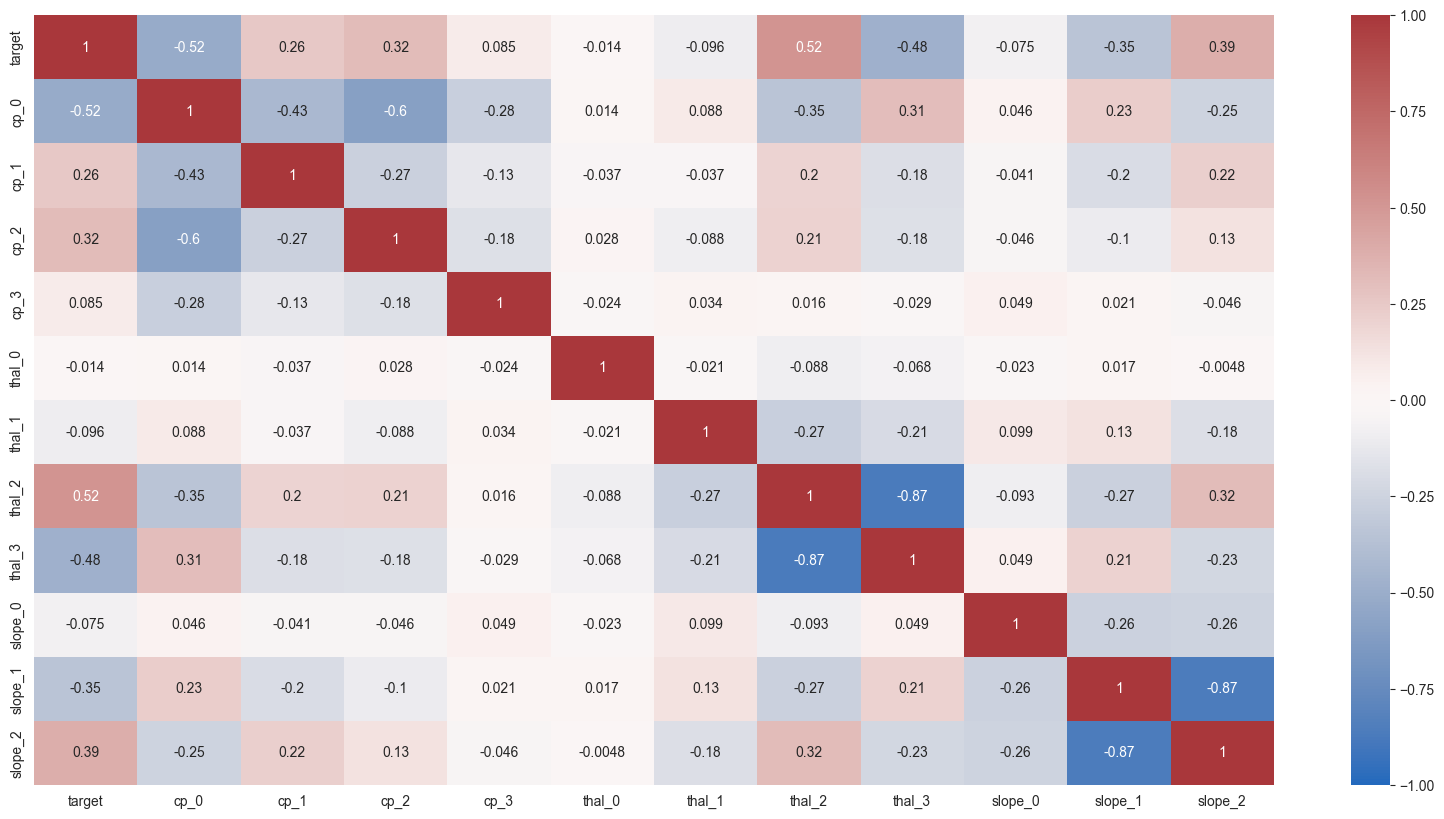

In [208]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(pd.concat([df.target, cp_dum, thal_dum, slope_dum], axis=1).corr(), vmin=-1, annot=True, cmap="vlag")

Получилось получить хорошие значения корреляции ;)

## Разделение выборки на тренировочную и тестовую

In [246]:
from sklearn.model_selection import train_test_split

x = df.drop(['target'], axis=1)
y = df['target']


## Масштабирование признаков

In [257]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [258]:
x = pd.DataFrame(scaler.transform(x), columns=x.columns)

In [259]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

## Подбор оптимальных признаков (RFE)

In [260]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train, y_train)

selected_features = list(x_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  20
Selected features:  ['age', 'sex', 'trestbps', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2']


Удалим признаки, не входящие в данный список.

In [261]:
x_train = x_train[selected_features]
x_test = x_test[selected_features]
x_train.head()

,age,sex,trestbps,fbs,restecg,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
576,52.0,1.0000e+00,152.0,1.0000e+00,1.0000e+00,178.0,2.0985e-16,1.2,-2.2877e-16,-5.5486e-17,1.2300e-16,9.9377e-17,1.0000e+00,2.0573e-17,-2.6862e-17,0.0,1.0000e+00,-5.7468e-17,1.0,-5.5311e-17
254,35.0,1.0000e+00,120.0,7.9126e-17,1.0000e+00,130.0,1.0000e+00,1.6,-2.2877e-16,1.0000e+00,1.2300e-16,9.9377e-17,1.0242e-16,2.0573e-17,-2.6862e-17,0.0,1.0000e+00,-5.7468e-17,1.0,-5.5311e-17
723,68.0,-1.0217e-16,120.0,7.9126e-17,1.1716e-16,115.0,2.0985e-16,1.5,-2.2877e-16,-5.5486e-17,1.2300e-16,1.0000e+00,1.0242e-16,2.0573e-17,-2.6862e-17,1.0,4.3512e-16,-5.7468e-17,1.0,-5.5311e-17
929,60.0,1.0000e+00,130.0,7.9126e-17,1.1716e-16,132.0,1.0000e+00,2.4,2.0000e+00,1.0000e+00,1.2300e-16,9.9377e-17,1.0242e-16,2.0573e-17,-2.6862e-17,0.0,1.0000e+00,-5.7468e-17,1.0,-5.5311e-17
539,64.0,1.0000e+00,170.0,7.9126e-17,1.1716e-16,155.0,2.0985e-16,0.6,-2.2877e-16,-5.5486e-17,1.2300e-16,9.9377e-17,1.0000e+00,2.0573e-17,-2.6862e-17,0.0,1.0000e+00,-5.7468e-17,1.0,-5.5311e-17


## Реализация метода K ближайших соседей (KNN)

In [262]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=3):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

## Реализация метода опорных векторов (SVM)

In [297]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-1, lamda_value=1E-1):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= 0, -1, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            dw = 0
            db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = self._lamda_value * self.w
                db = 0
            else:
                dw = self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "lamda_value": self._lamda_value}

## Подбор оптимальных гиперпараметров и кросс-валидация

### Собственная реализация KNNClassifier

In [264]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)
param_grid = [{"num_neighbors": [3, 5, 11, 13, 25]}]
searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Optimal num_neighbors = 3
Optimal score = 0.875223266745006


### Собственная реализация SVMClassifier

In [306]:
param_grid = [{"alpha_value": [1E-5, 1E-3, 1E-4],
               "lamda_value": [1E-5, 1E-3, 1E-4]}]

searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train, y_train)

optimal_alpha_value = searcher.best_params_["alpha_value"]
print("Optimal alpha_value =", optimal_alpha_value)
optimal_lamda_value = searcher.best_params_["lamda_value"]
print("Optimal lamda_value =", optimal_lamda_value)
print("Optimal score =", searcher.best_score_)

Optimal alpha_value = 1e-05
Optimal lamda_value = 1e-05
Optimal score = 0.489177438307873


### Библиотечная реализация LogisticRegression

In [307]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 1000.0}
Optimal score = 0.8600822561692129


### Библиотечная реализация SVM

In [267]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
Optimal score = 0.9750998824911867


### Библиотечная реализация KNN

In [268]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 7, 'weights': 'distance'}
Optimal score = 0.9837426556991774


### Библиотечная реализация Naive Bayes

In [269]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'priors': [0.33, 0.67], 'var_smoothing': 7.220809018385471e-05}
Optimal score = 0.8611809635722679


### Библиотечная реализация Decision Tree

In [270]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Optimal score = 0.9566216216216217


## Тестирование обученных моделей

In [271]:
scores = {}

### Собственная реализация KNNClassifier

In [272]:
from sklearn.metrics import accuracy_score

own_knn = KNNClassifier(num_neighbors=optimal_num_neighbors)

own_knn = own_knn.fit(x_train, y_train)

own_knn_y_test_pred = own_knn.predict(x_test)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)

scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

OWN_KNN score = 0.9223300970873787


### Собственная реализация SVMClassifier

In [308]:
own_svm = SVMClassifier(alpha_value=optimal_alpha_value,
                        lamda_value=optimal_lamda_value)

own_svm = own_svm.fit(x_train, y_train)

own_svm_y_test_pred = own_svm.predict(x_test)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)

scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

OWN_SVM score = 0.6699029126213593


### Библиотечная реализация LogisticRegression

In [274]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)

lib_logreg = lib_logreg.fit(x_train, y_train)

lib_logreg_y_test_pred = lib_logreg.predict(x_test)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)

scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

LIB_LOGREG score = 0.8543689320388349


### Библиотечная реализация SVM

In [275]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

lib_svm = lib_svm.fit(x_train, y_train)

lib_svm_y_test_pred = lib_svm.predict(x_test)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)

scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)

LIB_SVM score = 1.0


### Библиотечная реализация KNN

In [276]:
lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

lib_knn = lib_knn.fit(x_train, y_train)

lib_knn_y_test_pred = lib_knn.predict(x_test)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)

scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

LIB_KNN score = 0.6893203883495146


### Библиотечная реализация Naive Bayes

In [277]:
lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

lib_nb = lib_nb.fit(x_train, y_train)

lib_nb_y_test_pred = lib_nb.predict(x_test)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)

scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

LIB_NB score = 0.8543689320388349


### Библиотечная реализация Decision Tree

In [278]:
lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

lib_dt = lib_dt.fit(x_train, y_train)

lib_dt_y_test_pred = lib_dt.predict(x_test)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)

scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_DT score = 0.970873786407767


## Сравнение обученных моделей

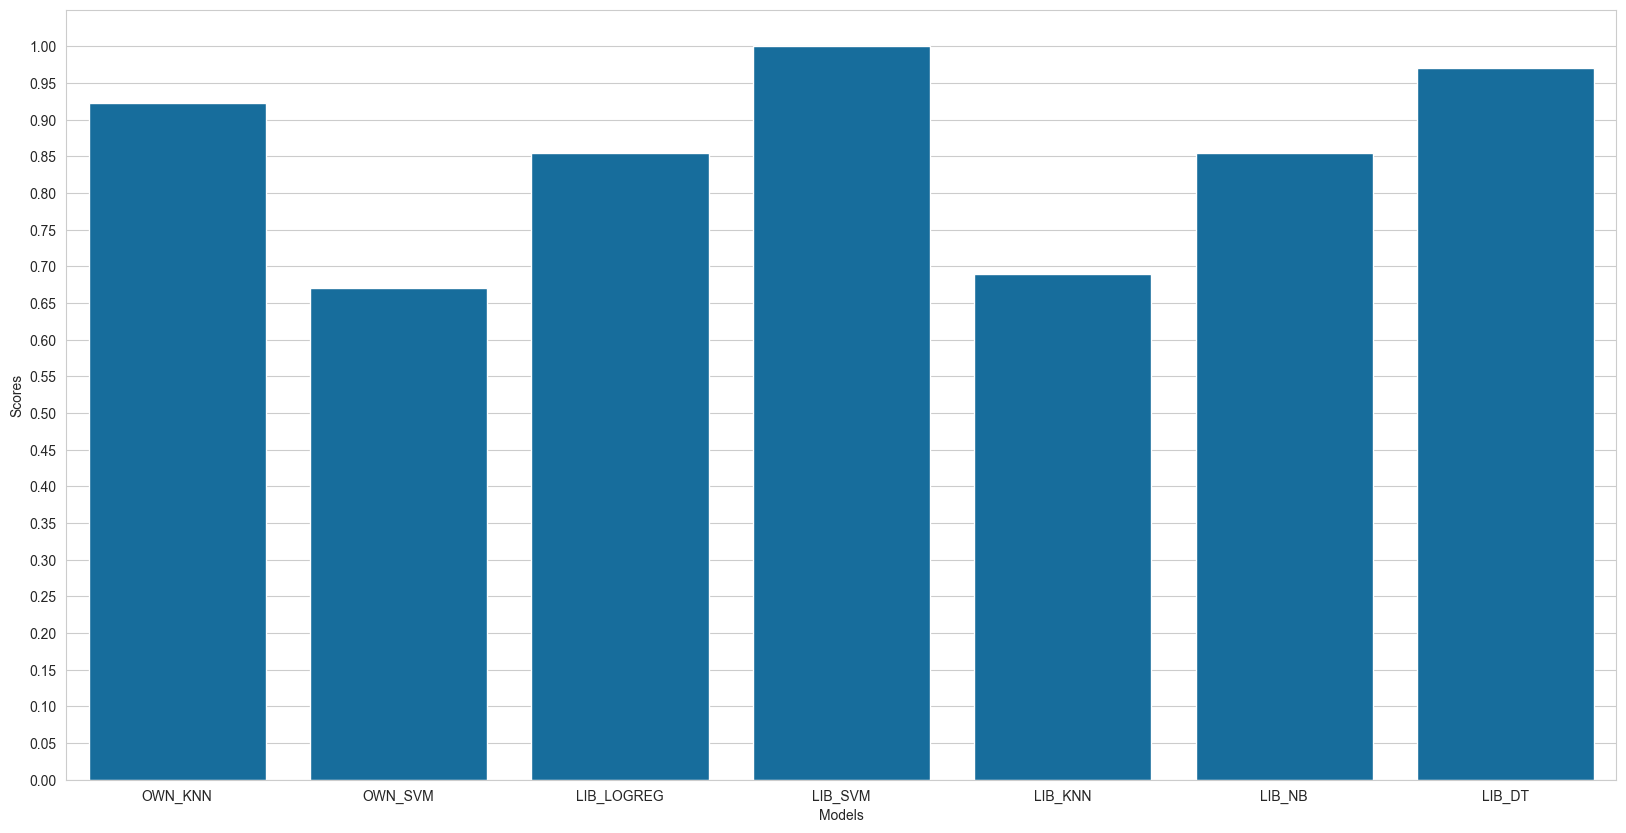

In [309]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

In [310]:
from sklearn.metrics import confusion_matrix

own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)

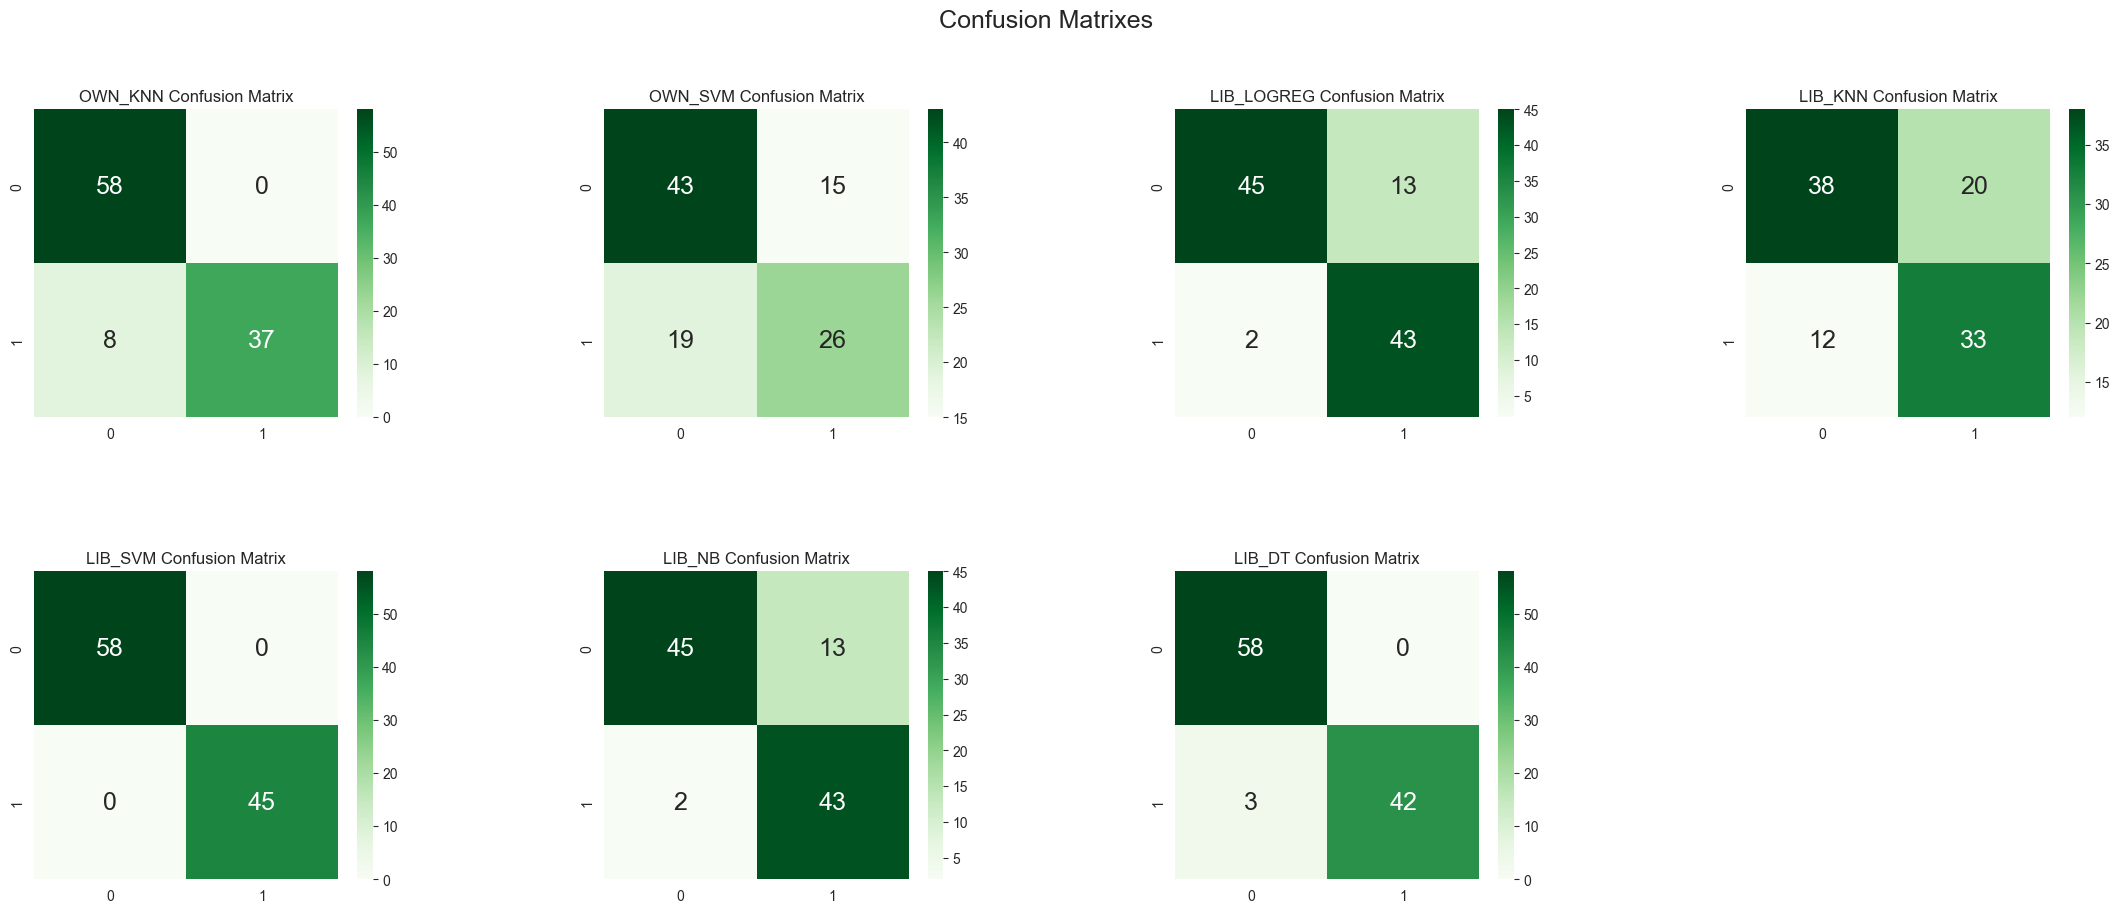

In [311]:
plt.figure(figsize=(27, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

## Выводы об обученных моделях первого датасета

Собственная реализация модели OWN_KNN показывает точность предсказания 0.9, что соответствует уровню лучших библиотечных моделей LIB_SVM, LIB_DT.
Собственная реалиация модели OWN_SVM и LIB_KNN показали себя худше всего.
Наибольшую точность предсказания показала LIB_SVM, наименьшую - OWN_SVM.
Есть гипотеза, что реализация OWN_SVM перетренировалась, так как, чтобы получить даже такие результаты, пришлось сильно уменьшить гиперпараметры. 

# Второй датасет

В качестве второго набора данных рассмотрим встроенный в **sklearn** небольшой датасет с информацией о разновидностях ириса.

Признаки:
- **sepal length (cm)** - длина чашелистика,
- **sepal width (cm)** - ширина чашелистика,
- **petal length (cm)** - длина лепестка,
- **petal width (cm)** - ширина лепестка.

Целевой признак:
- **target** - вид ириса.

In [313]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает количественными признаками для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

Однако целевой признак удобно закодировать целыми числами.

In [315]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Разведочный анализ (EDA)

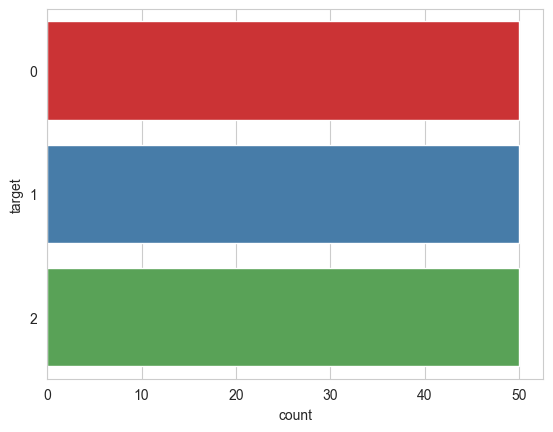

In [316]:
sns.countplot(data=df, y="target", palette="Set1")
plt.show()

In [317]:
df.target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

Датасет сбалансирован: всего имеется 3 вида ириса, при этом на каждый из них проходится ровно по 50 значений в данных.

Учитывая наличие количественных признаков, интересно посмотреть на их зависимости относительно друг друга.

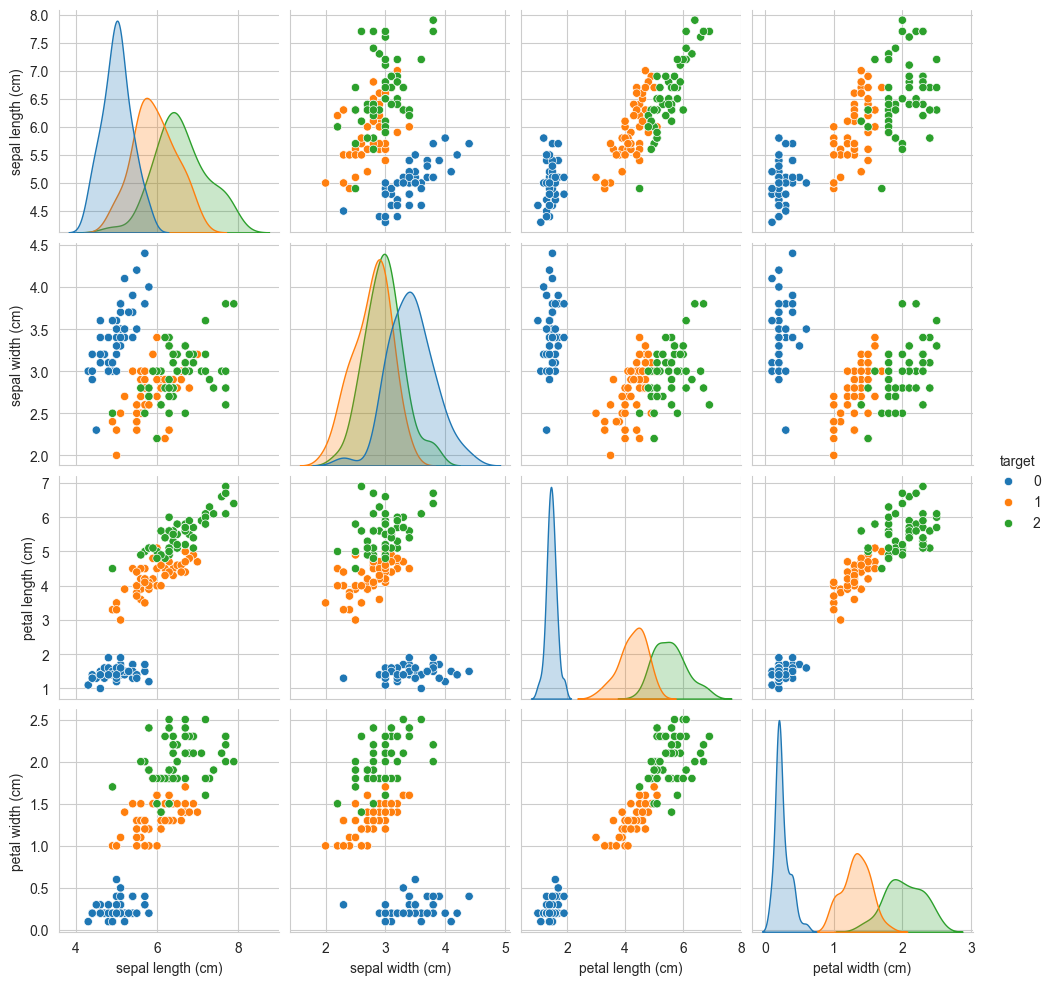

In [324]:
_ = sns.pairplot(df, hue='target', palette="tab10")

Исходя из распределений ясно, что ирис вида **0** заметно отличается по всем параметрам своего листа от двух других видов.
Остальные виды **1** и **2** имеют несколько совпадающих параметров листа, особенно **sepal length (cm)**. Поэтому данный признак лучше не учитывать для данных видов.

Интересно отдельно посмотреть на распределения каждого признака относительно целевого.

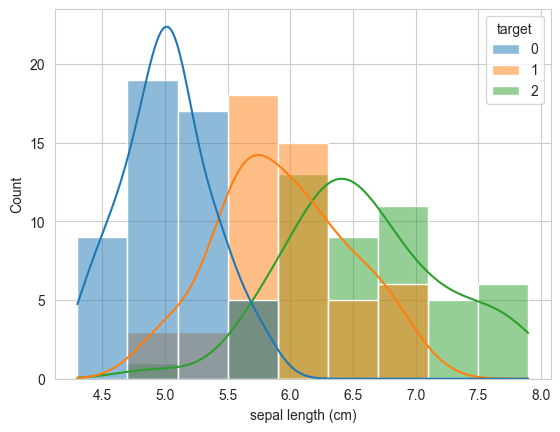

In [325]:
_ = sns.histplot(x='sepal length (cm)', hue='target', data=df, kde=True, palette="tab10")

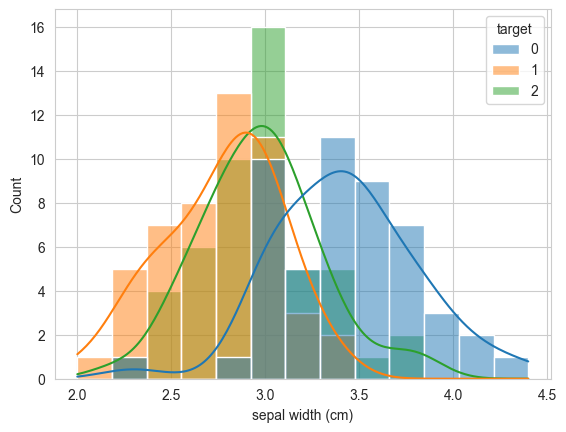

In [326]:
_ = sns.histplot(x='sepal width (cm)', hue='target', data=df, kde=True, palette="tab10")

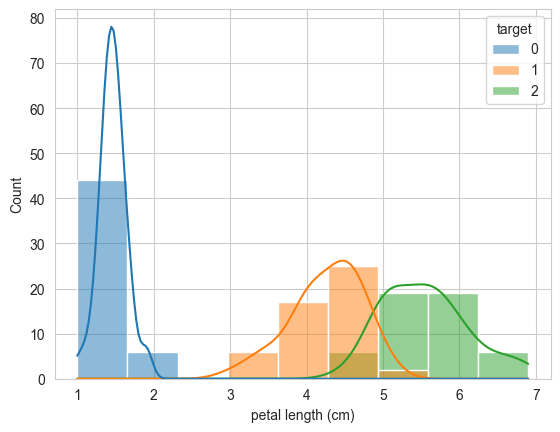

In [327]:
_ = sns.histplot(x='petal length (cm)', hue='target', data=df, kde=True, palette="tab10")

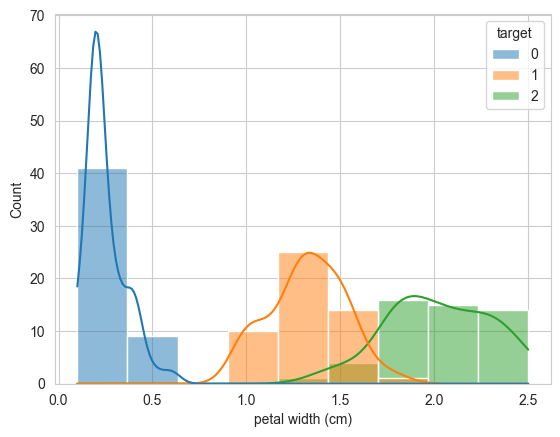

In [328]:
_ = sns.histplot(x='petal width (cm)', hue='target', data=df, kde=True, palette="tab10")

Графики показывают, что именно по признакам **petal** будет проще всего решать, какому классу принадлежит ирис.

Наконец, изучим корреляционную карту данного датасета.

<Axes: >

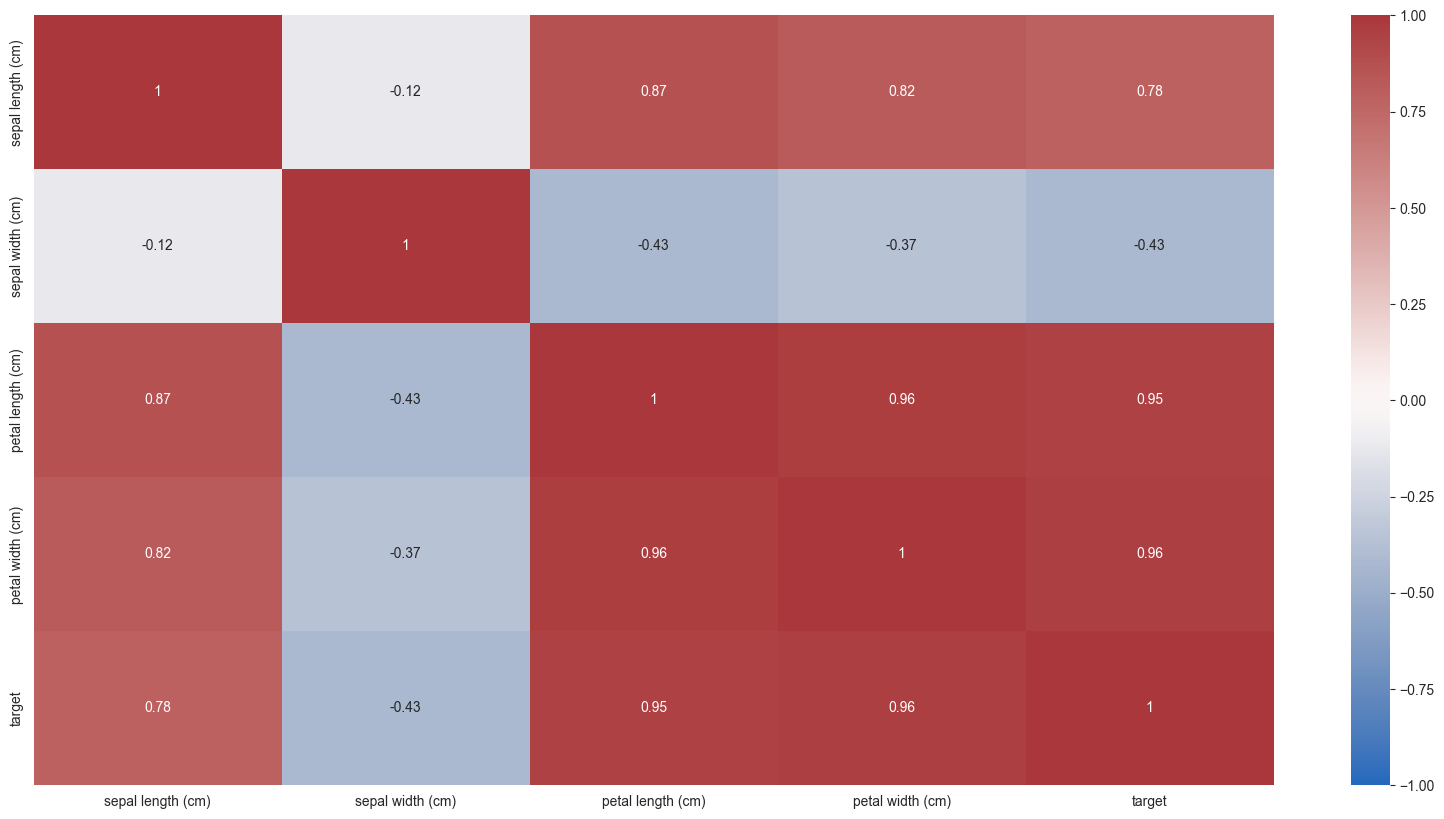

In [329]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), vmin=-1, annot=True, cmap="vlag")

**sepal width (cm)** имеет отрицательную корреляцию с **target**. Другие признаки имеют большую корреляцию с целевым признаком. При этом у данных признаков также наблюдается сильная корреляция между собой.

## Преобразование признаков (Feature Engineering)

В датасете содержится категориальный признак **target**, однако он уже закодирован и подлежит дальнейшему анализу.

## Разделение выборки на тренировочную и тестовую

In [335]:
x = df.drop(['target'], axis=1)
y = df['target']

## Масштабирование признаков

In [336]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [337]:
x = pd.DataFrame(scaler.transform(x), columns=x.columns)
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-8.1716,-4.6922,-2.8977,-3.3103
1,-8.4652,-7.3417,-2.8977,-3.3103
2,-8.7588,-6.2819,-2.9300,-3.3103
3,-8.9057,-6.8118,-2.8654,-3.3103
4,-8.3184,-4.1623,-2.8977,-3.3103


## Подбор оптимальных признаков (RFE)

In [338]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [339]:
rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train, y_train)

selected_features = list(x_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  3
Selected features:  ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Удалим признак **sepal length (cm)**, не входящий в данный список. Как было замечено ранее, по нему сложнее всего разделить **1** и **2** виды ириса.

In [340]:
x_train = x_train[selected_features]
x_test = x_test[selected_features]

## Подбор оптимальных гиперпараметров и кросс-валидация

### Собственная реализация KNNClassifier

In [341]:
cv = StratifiedKFold(5, shuffle=True, random_state=19)

param_grid = [{"num_neighbors": [3, 5, 7, 9, 11, 13, 15]}]

searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Optimal num_neighbors = 3
Optimal score = 0.874074074074074


### Собственная реализация SVMClassifier

In [365]:
param_grid = [{"alpha_value": [1E-2, 1E-3, 1E-4, 1E-5],
               "lamda_value": [1E-2, 1E-3, 1E-4, 1E-5]}]

searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_alpha_value = searcher.best_params_["alpha_value"]
print("Optimal alpha_value =", optimal_alpha_value)
optimal_lamda_value = searcher.best_params_["lamda_value"]
print("Optimal lamda_value =", optimal_lamda_value)
print("Optimal score =", searcher.best_score_)

Optimal alpha_value = 0.01
Optimal lamda_value = 0.01
Optimal score = 0.6444444444444445


### Библиотечная реализация LogisticRegression

In [347]:
param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 10.0}
Optimal score = 0.9481481481481481


### Библиотечная реализация SVM

In [348]:
param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
Optimal score = 0.9555555555555555


### Библиотечная реализация KNN

In [349]:
param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 5, 'weights': 'uniform'}
Optimal score = 0.9407407407407407


### Библиотечная реализация Naive Bayes

In [350]:
param_grid = [{"priors": [[0.5, 0.3, 0.2], [0.3, 0.3, 0.4], [0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.2, 0.3, 0.5]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'priors': [0.5, 0.3, 0.2], 'var_smoothing': 0.005994842503189409}
Optimal score = 0.9555555555555555


### Библиотечная реализация Decision Tree

In [351]:
param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Optimal score = 0.9555555555555555


## Тестирование обученных моделей

In [352]:
scores = {}

### Собственная реализация KNNClassifier

In [355]:
own_knn = KNNClassifier(num_neighbors=optimal_num_neighbors)

own_knn = own_knn.fit(x_train, y_train)

own_knn_y_test_pred = own_knn.predict(x_test)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)

scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

OWN_KNN score = 0.8


### Собственная реализация SVMClassifier

In [366]:
own_svm = SVMClassifier(alpha_value=optimal_alpha_value,
                        lamda_value=optimal_lamda_value)

own_svm = own_svm.fit(x_train, y_train)

own_svm_y_test_pred = own_svm.predict(x_test)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)

scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

OWN_SVM score = 0.8


### Библиотечная реализация LogisticRegression

In [357]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)

lib_logreg = lib_logreg.fit(x_train, y_train)

lib_logreg_y_test_pred = lib_logreg.predict(x_test)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)

scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

LIB_LOGREG score = 0.9333333333333333


### Библиотечная реализация SVM

In [358]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

lib_svm = lib_svm.fit(x_train, y_train)

lib_svm_y_test_pred = lib_svm.predict(x_test)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)

scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)

LIB_SVM score = 0.9333333333333333


### Библиотечная реализация KNN

In [359]:
lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

lib_knn = lib_knn.fit(x_train, y_train)

lib_knn_y_test_pred = lib_knn.predict(x_test)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)

scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

LIB_KNN score = 1.0


### Библиотечная реализация Naive Bayes

In [360]:
lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

lib_nb = lib_nb.fit(x_train, y_train)

lib_nb_y_test_pred = lib_nb.predict(x_test)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)

scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

LIB_NB score = 1.0


### Библиотечная реализация Decision Tree

In [361]:
lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

lib_dt = lib_dt.fit(x_train, y_train)

lib_dt_y_test_pred = lib_dt.predict(x_test)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)

scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_DT score = 1.0


## Сравнение обученных моделей

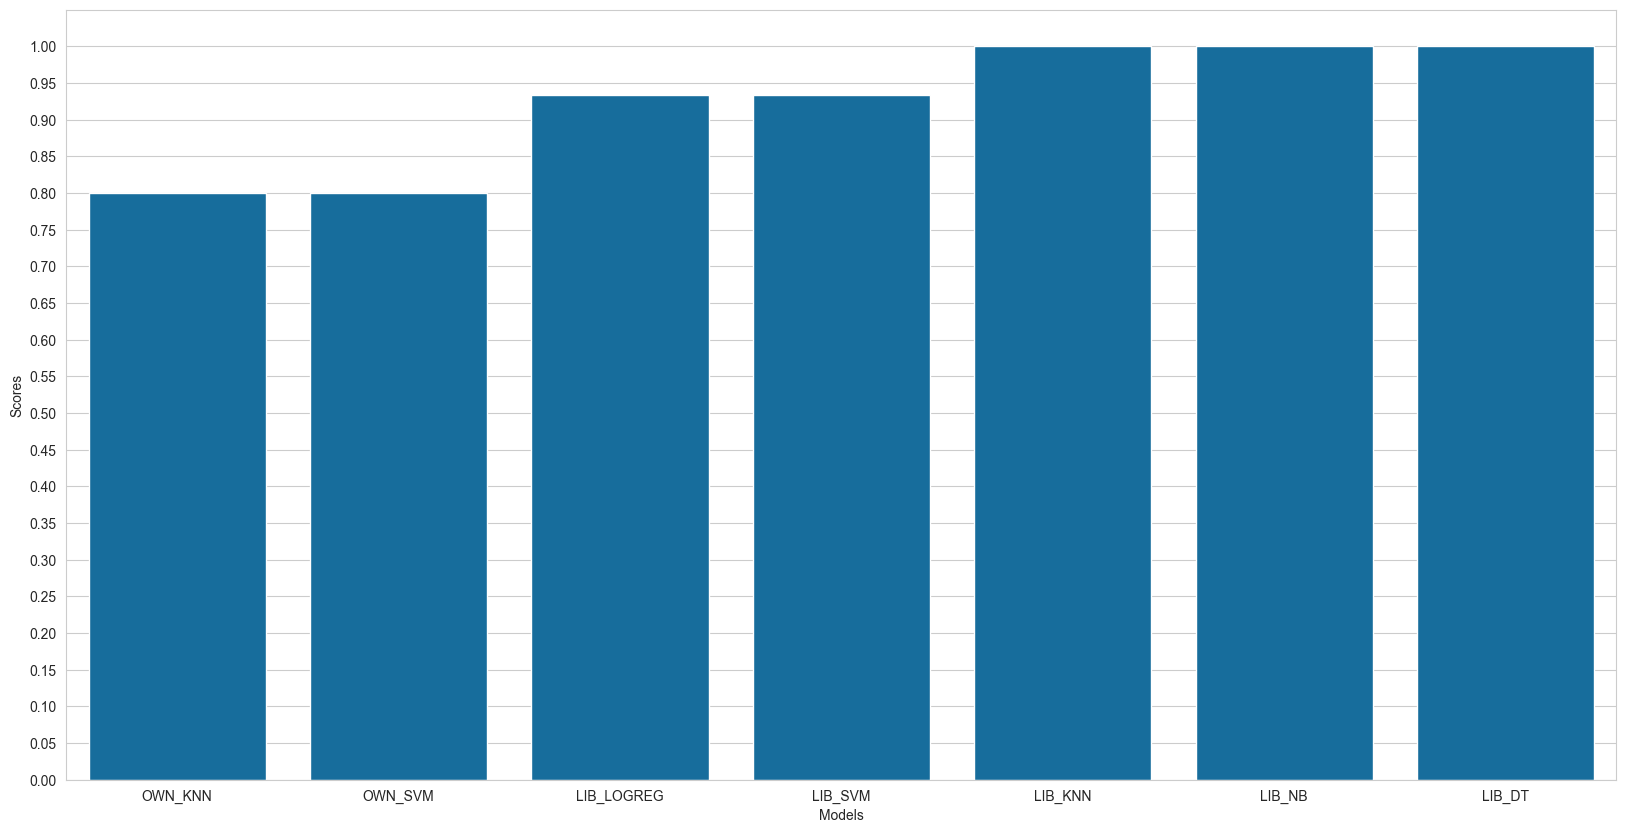

In [369]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

In [367]:
own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)

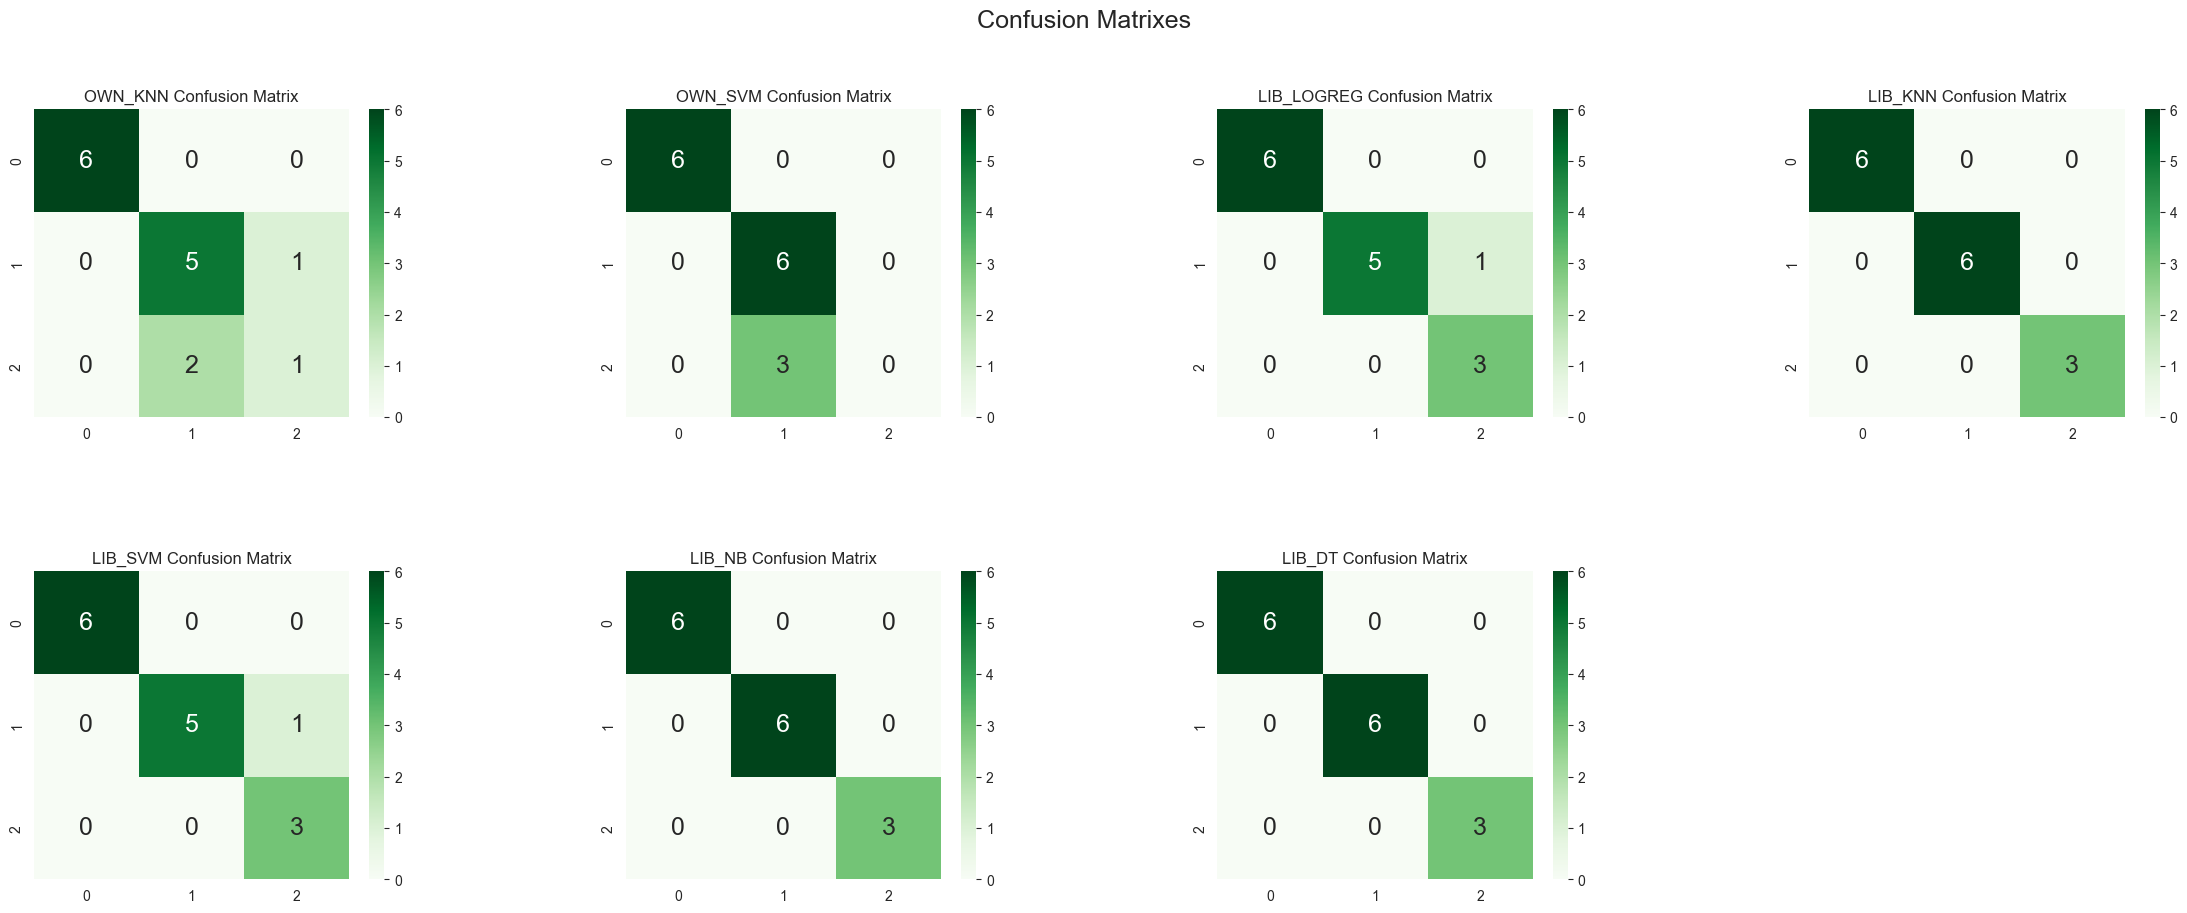

In [370]:
plt.figure(figsize=(28, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

## Выводы об обученных моделях второго датасета

Собственные реализации моделей показали точность предсказания 0.8, что соответствует самым низким результатам.
Наибольшую точность предсказания показала библиотечная реализация метода ближайших соседей LIB_KNN.